In [195]:
import numpy as np
from numpy.linalg import norm, inv
import matplotlib.pyplot as plt
from time import time

# Chapter 2 Practical Works

### Exercise 1 
Consider the Tikhonov regularization problem given by
$$\min\limits_{x\in\mathbb{R}^d} f(x) = \dfrac{1}{2}\|Ax-b\|^2 + \dfrac{\gamma}{2}\|x\|^2.$$

In [212]:
np.random.seed(42) 
m, n = 100, 50 
A = np.random.randn(m, n) 
b = np.random.randn(m, 1)

gamma = 0.5

g = lambda x: norm(A@x - b)**2/2

# Choose the optimal lambda
L = np.linalg.norm(A.T @ A, 2)
_lambda = 1/L

#### 1. Discuss the objective of the Tikhonov regularization problem, and give an interpretation of the parameter 

We can interpret the regularizer $\dfrac{\gamma}{2}\|x\|^2$ as to penalize on the norm of $x$. In other words, it forces the solution to have smaller norm. When $\gamma$ is large, the penalization is more intense.

#### 2. Solve the problem using Gradient descent, Proximal point, Proximal gradient and Douglas-Rachford algorithms

We will work on the generalized problem where

$$f(x) = \dfrac{1}{2}\|Ax-b\|^2 + \dfrac{1}{2}\|Bx\|^2.$$

 In the special case, we have $B^\top B = \gamma I$. Let
    $$g(x) = \dfrac{1}{2}\|Ax-b\|^2$$
    and 
    $$h_2(x) = \dfrac{1}{2}\|Bx\|^2.$$

In [164]:
h2 = lambda x: gamma*norm(x)/2
f = lambda x: g(x) + h2(x)

##### Gradient descent

We have
$$\nabla g(x) = A^\top (Ax- b), \nabla h_2(x) = B^\top Bx.$$

Hence, we can compute $\nabla f(x) = \nabla g(x) + \nabla h_2(x)$.


In [165]:
grad_g = lambda x: A.T@(A@x-b)
grad_h2 = lambda x: gamma*x

grad_f = lambda x: grad_g(x) + grad_h2(x)

In [207]:
def gradient_descent(f, grad_f, 
                     x0=np.random.randn(n,1), 
                     lr=0.0001, tol = 0.1, max_iter = int(1e6),
                     plot=True):
  
  start = time()

  iter = 0
  x = x0
  history = [x0]

  for iter in range(max_iter):
    x_new = x - lr*grad_f(x)
    history.append(x_new)

    diff = np.abs(f(x) - f(x_new))

    if diff < tol:
      print(f"Terminated after {iter} iterations. Time: {time()-start}s")
      print(f"Final difference: {diff}")
      break

    x = x_new

  if plot:
    plt.plot([f(x) for x in history])
    plt.xlabel('Iteration')
    plt.ylabel('$f(x)$')

    plt.show()
    

  return x

Terminated after 2046 iterations. Time: 0.04997611045837402s
Final difference: 0.09976597875356674


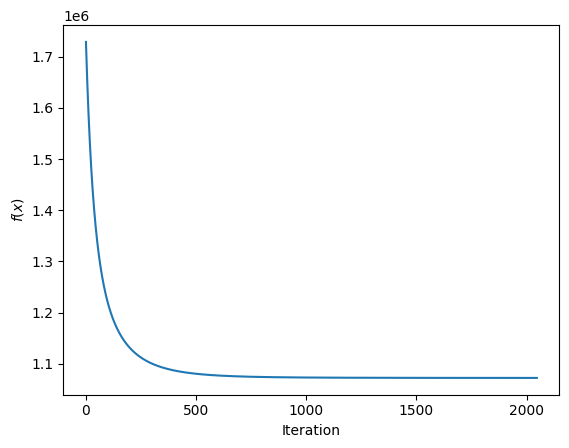

In [208]:
x_opt = gradient_descent(f, grad_f)

##### Proximal point
We have
$$\begin{aligned}
y\in \mathrm{prox}_{\lambda f} (x) 
& \Leftrightarrow x = y + \nabla f(y) \\
& \Leftrightarrow x = y + \lambda(A^\top (Ay- b) + B^\top By) \\
& \Leftrightarrow \dfrac{1}{\lambda}x = \dfrac{1}{\lambda}y + (A^\top A+B^\top B)y - A^\top b \\
& \Leftrightarrow y = \left(A^\top A + B^\top B + \dfrac{1}{\lambda}I\right)^{-1}\left(A^\top b+\dfrac{1}{\lambda}x\right).
\end{aligned}$$


In [213]:
def prox_f(x):
    return inv(A.T@A + (gamma + 1/_lambda)*np.eye(n))@(A.T@b + x/_lambda)

In [ ]:
def proximal_point(f, prox_f, 
                   x0 = np.random.randn(n,1), 
                   tol=1e-6, max_iter=int(1e6), plot=True):
  
  start = time()

  iter = 0
  x = x0
  history = [x0]

  for iter in range(max_iter):
    x_new = prox_f(x)

    history.append(x_new)
    diff = np.abs(f(x_new) - f(x))

    if diff < tol:
      print(f"Terminated after {iter} iterations. Time: {time() - start}s")
      print(f"Final difference: {diff}")
      break


    x = x_new

  if iter == max_iter - 1: print(f"Reached maximal {iter} iterations")
  if plot:
    plt.plot([f(x) for x in history])
    plt.xlabel('Iteration')
    plt.ylabel('$f(x)$')

    plt.show()
  return x

Terminated after 357 iterations. Time: 0.0784907341003418s
Final difference: 9.865034371614456e-07


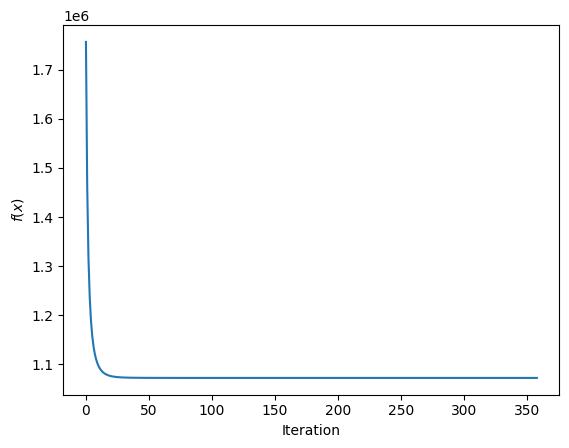

In [211]:
x_opt = proximal_point(f, prox_f)

##### Proximal gradient

We have $\mathrm{prox}_{\lambda h_2}(x) = \dfrac{1}{1+\lambda\gamma}(x)$

In [215]:
def proximal_gradient(f,  
                      grad_g, prox_h, 
                      x0 = np.random.randn(n,1), 
                      tol = 1e-6, max_iter=int(1e6), plot=True):
  
  start = time()

  iter = 0
  x = x0
  history = [x0]

  for iter in range(max_iter):
    x_new = prox_h(x - _lambda*grad_g(x))

    history.append(x_new)
    diff = np.abs(f(x_new) - f(x))

    if diff < tol:
      print(f"Terminated after {iter} iterations. Time: {time()-start}s")
      print(f"Final difference: {diff}")
      break
    
    x = x_new

  if iter == max_iter - 1: print(f"Reached maximal {iter} iterations")
  if plot:
    plt.plot([f(x) for x in history])
    plt.xlabel('Iteration')
    plt.ylabel('$f(x)$')

    plt.show()

  return x

Terminated after 218 iterations. Time: 0.004865884780883789s
Final difference: 9.72636115648129e-07


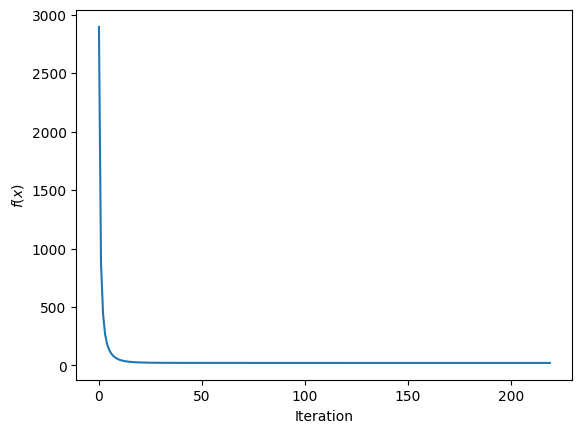

In [219]:
prox_h2 = lambda x: x/(1+_lambda*gamma)
x_opt = proximal_gradient(f, grad_g, prox_h2)

##### Douglas-Rachford
We have $\mathrm{prox}_{\lambda g}(x) = \left(A^\top A + \dfrac{1}{\lambda} I\right)^{-1}\left(A^\top b + \dfrac{1}{\lambda}x\right)$.

Therefore, $\mathrm{refl}_{\mathrm{prox}_{\lambda g}}(x) = 2\mathrm{prox}_{\lambda g}(x)-x$ and $\mathrm{refl}_{\mathrm{prox}_{\lambda h_2}}(x) = (1-2\lambda\gamma)x$

In [222]:
def douglas_rachford(f, 
                     prox_g, refl_g, refl_h, 
                     y0 = np.random.randn(A.shape[1],1),
                     tol = 1e-6, max_iter=int(1e6), plot=True):
  start = time()
  y = y0
  x = prox_g(y)
  history = [x]

  for iter in range(max_iter):
    y = (y + refl_h(refl_g(y)))/2
    x_new = prox_g(y)

    history.append(x_new)

    diff = np.abs(f(x_new) - f(x))

    if diff < tol:
      print(f"Terminated after {iter} iterations. Time: {time()-start}s")
      print(f"Final difference: {diff}")
      break
   
    x = x_new
  
  if iter == max_iter - 1: print(f"Reached maximal {max_iter} iterations")
  if plot:
    plt.plot([f(x) for x in history])
    plt.xlabel('Iteration')
    plt.ylabel('$f(x)$')

    plt.show()
  return x

Terminated after 122 iterations. Time: 0.0384364128112793s
Final difference: 8.660540835592201e-07


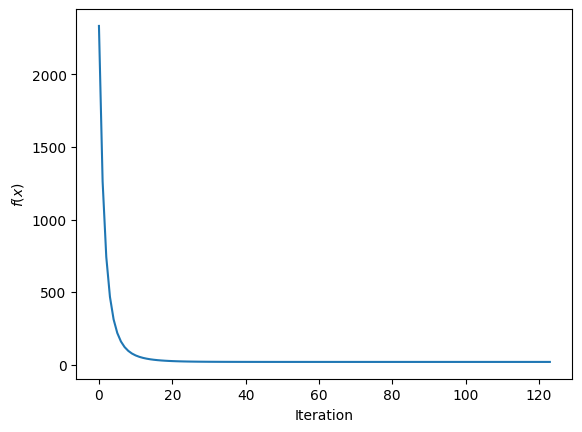

In [225]:
h2 = lambda x: gamma*norm(x)/2
f = lambda x: g(x) + h2(x)

def prox_g(x):
  return inv(A.T@A + np.eye(n)/_lambda)@(A.T@b + x/_lambda)

def refl_g(x):
  return 2*prox_g(x) - x


def refl_h2(x):
  return 2*prox_h2(x) - x

x_opt = douglas_rachford(f, prox_h2, refl_h2, refl_g)

#### 3. Compare the convergence rates of the four codes.

It is not plausible to compare Gradient descent with the others because the meaning of learning rates are different. Among, Proximal point, Proximal gradient and Douglas-Rachford's with optimal learning rate $\lambda = \dfrac{1}{L}$, using that $g$ is $L$-Lipschitz, we can see that Proximal gradient consume least time, as it makes uses of both gradient and proximity comparing to Proximal point, while computes less that Douglas-Rachford's in each iteration.

#### 4. Provide a code to solve the general problem

We shall use gradient descent

Terminated after 242 iterations. Time: 0.02707529067993164s
Final difference: 0.09903714566454624


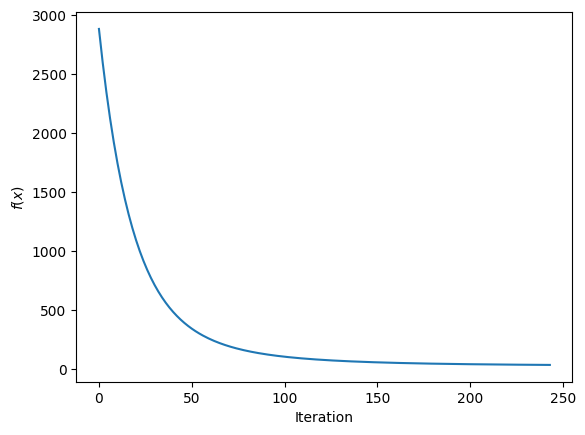

In [226]:
p = 50
B = np.random.randn(p, n)

h2 = lambda x: norm(B@x)/2
grad_h2 = lambda x: B.T@B@x

f = lambda x: g(x) + h2(x)
grad_f = lambda x: grad_g(x) + grad_h2(x)

x_opt = gradient_descent(f, grad_f)

#### 5. Discuss the objective of the generalized Tikhonov regularization problem, and give an interpretation of the matrix $B$.

The use of a matrix instead of a constant raises more flexibility for regularization. This can be applied when we especially want to to enforce smoothness if the underlying vector is believed to be mostly continuous.

### Exercise 2

####
1. Why is the last term $\gamma\|x\|_1$ usually called the sparsity enforcement? Make a drawing in the two-dimensional case for illustration.
2. Discuss the objective of the LASSO problem, and give an interpretation of the parameter.

  
  As the name LASSO (Least Absolute Shrinkage and Selection Operator) suggests, the term "sparsity enforcement" reflects LASSO's ability to encourage simpler models with fewer active features, which is particularly valuable in high-dimensional datasets. In other words, it forces as many as possible numbers of features to be zero. As $\gamma$ is larger, the selection enforcement is more intense.

#### 3. Solve the problem using Proximal gradient and Douglas-Rachford

##### Proximal gradient

Let $h_1 = \gamma\|x\|_1$. We have $\mathrm{prox}_{\lambda h_1}(x)_i = \mathrm{sign}(x_i)\max(|x_i|-\lambda\gamma, 0)$.

In [175]:
def soft_threshold(x, lam):
    return np.sign(x) * np.maximum(np.abs(x) - lam, 0)

h1 = lambda x: gamma*norm(x, 1)
prox_h1 = lambda x: soft_threshold(x, gamma*_lambda)
f = lambda x: g(x) + h1(x)

L = np.linalg.norm(A.T @ A, 2)
_lambda = 1/L
x_opt, history = proximal_gradient(f, grad_g, prox_h1)

Terminated after 113 iterations
Final difference: 9.740356361476188e-07


##### Douglas-Rachford

In [176]:
refl_h1 = lambda x: 2*prox_h1(x) - x
x_opt, history = douglas_rachford(f, prox_g, refl_g, refl_h1)

Terminated after 124 iterations
Final difference: 9.908578775252863e-07


### Exercise 3

In [182]:
b = plt.imread(r"blurred.jpg").reshape(-1, 1)

####
3. By using this objective function, we hypothesized that the original image has continuous gradient (difference between adjacent pixels). The first element is to find the nearest image, the second element is for continuous gradient hypothesis.

#### 4. Construct the matrix $F$.

In [189]:
F1 = np.zeros([100, 100])

for i in range(100):
  if i % 10 != 9:
    F1[i, i] = 1
    F1[i, i+1] = -1

F2 = np.zeros([100, 100])

for i in range(100):
  if i < 90:
    F2[i, i] = 1
    F2[i, i+10] = -1

F = np.vstack([F1, F2])

####